# Assignment 2: Build a CNN for image recognition.

## Due Date:  March 31, 11:59PM

### Name: Harris Spahic


## Introduction:

1. In this assignment, you will build Convolutional Neural Network to classify CIFAR-10 Images.
2. You can directly load dataset from many deep learning packages.
3. You can use any deep learning packages such as pytorch, keras or tensorflow for this assignment.

## Requirements:

1. You need to load cifar 10 data and split the entire training dataset into training and validation.
2. You will implement a CNN model to classify cifar 10 images with provided structure.
3. You need to plot the training and validation accuracy or loss obtained from above step.
4. Then you can use tuned hyper-parameters to train using the entire training dataset.
5. You should report the testing accuracy using the model with complete data.
6. You may try to change the structure (e.g, add BN layer or dropout layer,...) and analyze your findings.

## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

## Batch Normalization (BN)

### Background:

- Batch Normalization is a technique to speed up training and help make the model more stable.
- In simple words, batch normalization is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

- For more detailed information, you may refer to the original paper: https://arxiv.org/pdf/1502.03167.pdf.

### BN Algorithm:

- Input: Values of $x$ over a mini-batch: $\mathbf{B}$ = $\{x_1,..., x_m\};$
- Output: $\{y_i = BN_{\gamma,\beta}(x_i)\}$, $\gamma, \beta$ are learnable parameters

Normalization of the Input:
$$\mu_{\mathbf{B}} = \frac{1}{m}\sum_{i=1}^m x_i$$
$$\sigma_{\mathbf{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathbf{B}})^2$$
$$\hat{x_i} = \frac{x_i - \mu_{\mathbf{B}}}{\sqrt{\sigma_{\mathbf{B}}}^2 + \epsilon}$$
Re-scaling and Offsetting:
$$y_i = \gamma \hat{x_i} + \beta = BN_{\gamma,\beta}(x_i)$$


### Advantages of BN:
1. Improves gradient flow through the network.
2. Allows use of saturating nonlinearities and higher learning rates.
3. Makes weights easier to initialize.
4. Act as a form of regularization and may reduce the need for dropout.

### Implementation:

- The batch normalization layer has already been implemented in many packages. You may simply call the function to build the layer. For example: torch.nn.BatchNorm2d() using pytroch package, keras.layers.BatchNormalization() using keras package.
- The location of BN layer: Please make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

## 1. Data preparation

### 1.1. Load data


In [31]:
# Load Cifar-10 Data
# This is just an example, you may load dataset from other packages.
import keras
import numpy as np
import tensorflow as tf

print(keras.__version__)

### If you can not load keras dataset, un-comment these two lines.
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))

2.11.0
shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels (5 points)

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Implement a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [32]:
def to_one_hot(y, num_class=10):
  data = np.zeros((y.shape[0], num_class))
  for i in range(y.shape[0]):
    data[i, y[i]] = 1
  return data

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])
print(y_train.shape)
print(y_test.shape)

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(50000, 1)
(10000, 1)


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets (5 points)

Randomly partition the 50K training samples to 2 sets: 
* a training set containing 40K samples: x_tr, y_tr
* a validation set containing 10K samples: x_val, y_val


In [33]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train_vec, test_size=0.2, random_state=42)

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters (50 points)

- Build a convolutional neural network model using the below structure:

- It should have a structure of: Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax

- In the graph 3@32x32 means the dimension of input image, 32@30x30 means it has 32 filters and the dimension now becomes 30x30 after the convolution.
- All convolutional layers (Conv) should have stride = 1 and no padding.
- Max Pooling has a pool size of 2 by 2.




<img src="network.PNG"/>

- You may use the validation data to tune the hyper-parameters (e.g., learning rate, and optimization algorithm)
- Do NOT use test data for hyper-parameter tuning!!!
- Try to achieve a validation accuracy as high as possible.

In [13]:
# Build the model
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape =(32,32,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (4,4), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_2 (Dense)             (None, 256)              

In [6]:
# Define model optimizer and loss function
from keras import optimizers

model.compile(optimizers.RMSprop(lr=0.001),
              loss='categorical_crossentropy',
              metrics=["accuracy"])



/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
# Train the model and store model parameters/loss values
history = model.fit(x_tr, y_tr, batch_size=128, epochs=50, validation_data=(x_val, y_val))

# Why is the batch_size=128?
# Why is the epochs = 50? -> Epochs are hyperparameters


Epoch 1/50
313/313 [==============================] - 2s 7ms/step - loss: 0.5285 - accuracy: 0.8225 - val_loss: 1.9744 - val_accuracy: 0.5990
Epoch 2/50
313/313 [==============================] - 2s 7ms/step - loss: 0.4607 - accuracy: 0.8490 - val_loss: 2.2082 - val_accuracy: 0.6060
Epoch 3/50
313/313 [==============================] - 2s 6ms/step - loss: 0.4079 - accuracy: 0.8664 - val_loss: 2.5237 - val_accuracy: 0.5622
Epoch 4/50
313/313 [==============================] - 2s 8ms/step - loss: 0.3547 - accuracy: 0.8851 - val_loss: 2.7454 - val_accuracy: 0.6270
Epoch 5/50
313/313 [==============================] - 2s 6ms/step - loss: 0.3124 - accuracy: 0.9025 - val_loss: 2.4792 - val_accuracy: 0.5892
Epoch 6/50
313/313 [==============================] - 2s 6ms/step - loss: 0.2933 - accuracy: 0.9083 - val_loss: 2.6315 - val_accuracy: 0.6040
Epoch 7/50
313/313 [==============================] - 2s 6ms/step - loss: 0.2632 - accuracy: 0.9207 - val_loss: 3.0573 - val_accuracy: 0.5822
Epoch 

## 3. Plot the training and validation loss curve versus epochs. (5 points)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


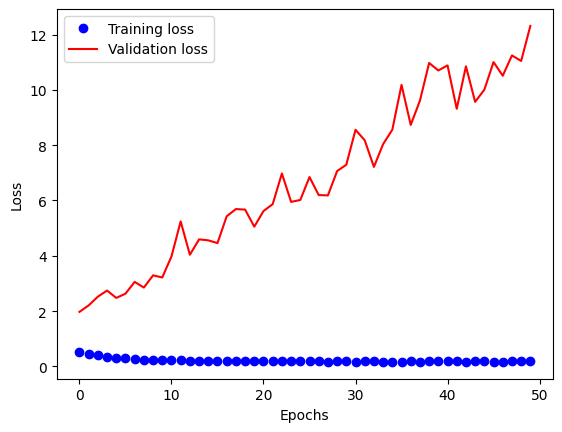

In [9]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline 
#Makes it so plot is only dependent on this block

epochs = range(50)
print(history.history.keys())
train_acc = history.history['loss']
valid_acc = history.history['val_loss']
plt.plot(epochs, train_acc, 'bo', label="Training loss")
plt.plot(epochs, valid_acc, 'r', label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 4. Train (again) and evaluate the model (5 points)

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [10]:
#<Compile your model again (using the same hyper-parameters you tuned above)>
from keras import optimizers

model.compile(optimizers.RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=["accuracy"])

In [11]:
#<Train your model on the entire training set (50K samples)>
history = model.fit(x_train, y_train_vec, batch_size=128, epochs=25)

Epoch 1/25
391/391 [==============================] - 3s 6ms/step - loss: 1.4066 - accuracy: 0.8806
Epoch 2/25
391/391 [==============================] - 3s 7ms/step - loss: 0.9161 - accuracy: 0.8838
Epoch 3/25
391/391 [==============================] - 2s 5ms/step - loss: 0.7182 - accuracy: 0.8972
Epoch 4/25
391/391 [==============================] - 2s 5ms/step - loss: 0.5891 - accuracy: 0.9088
Epoch 5/25
391/391 [==============================] - 2s 5ms/step - loss: 0.4925 - accuracy: 0.9204
Epoch 6/25
391/391 [==============================] - 2s 6ms/step - loss: 0.4167 - accuracy: 0.9280
Epoch 7/25
391/391 [==============================] - 3s 6ms/step - loss: 0.3548 - accuracy: 0.9368
Epoch 8/25
391/391 [==============================] - 2s 6ms/step - loss: 0.3043 - accuracy: 0.9441
Epoch 9/25
391/391 [==============================] - 2s 5ms/step - loss: 0.2617 - accuracy: 0.9505
Epoch 10/25
391/391 [==============================] - 2s 6ms/step - loss: 0.2279 - accuracy: 0.9555

## 5. Evaluate the model on the test set (5 points)

Do NOT use the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [12]:
# Evaluate your model performance (testing accuracy) on testing data.
loss_and_acc = model.evaluate(x_test, y_test_vec)


313/313 [==============================] - 1s 3ms/step - loss: 6.1628 - accuracy: 0.6456


## 6. Building model with new structure (25 points)
- In this section, you can build your model with adding new layers (e.g, BN layer or dropout layer, ...).
- If you want to regularize a ```Conv/Dense layer```, you should place a ```Dropout layer``` before the ```Conv/Dense layer```.
- You can try to compare their loss curve and testing accuracy and analyze your findings.
- You need to try at lease two different model structures.

In [14]:
# Idea1: Implement BN between every set of two layers and switch optimizer to Adam due to dense data
model2 = models.Sequential()
model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(64, (6,6), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.BatchNormalization())
model2.add(layers.Dense(256, activation="relu"))
model2.add(layers.Dense(10, activation="softmax"))

In [16]:
model2.compile(optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=["accuracy"])

history2 = model2.fit(x_tr, y_tr, batch_size=100, epochs=25, validation_data=(x_val, y_val))

Epoch 1/25
400/400 [==============================] - 4s 7ms/step - loss: 1.3525 - accuracy: 0.5411 - val_loss: 1.2666 - val_accuracy: 0.5699
Epoch 2/25
400/400 [==============================] - 2s 6ms/step - loss: 0.8854 - accuracy: 0.6928 - val_loss: 0.9034 - val_accuracy: 0.6864
Epoch 3/25
400/400 [==============================] - 3s 7ms/step - loss: 0.6775 - accuracy: 0.7644 - val_loss: 0.8798 - val_accuracy: 0.7053
Epoch 4/25
400/400 [==============================] - 3s 6ms/step - loss: 0.5347 - accuracy: 0.8127 - val_loss: 0.8810 - val_accuracy: 0.7100
Epoch 5/25
400/400 [==============================] - 2s 6ms/step - loss: 0.4149 - accuracy: 0.8549 - val_loss: 0.9651 - val_accuracy: 0.7045
Epoch 6/25
400/400 [==============================] - 2s 6ms/step - loss: 0.3168 - accuracy: 0.8912 - val_loss: 0.9679 - val_accuracy: 0.7120
Epoch 7/25
400/400 [==============================] - 2s 6ms/step - loss: 0.2313 - accuracy: 0.9210 - val_loss: 1.0725 - val_accuracy: 0.7154
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


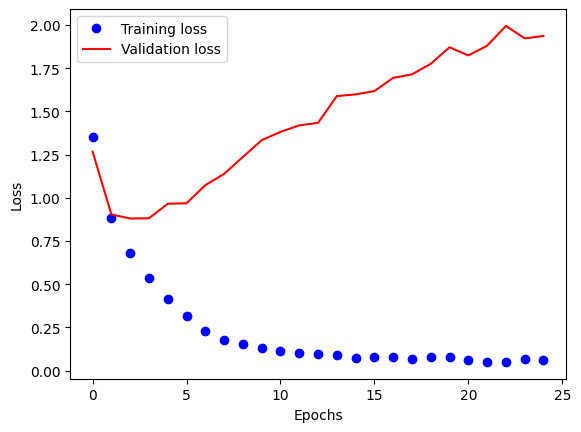

In [17]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline 
#Makes it so plot is only dependent on this block

epochs = range(25)
print(history2.history.keys())
train_acc = history2.history['loss']
valid_acc = history2.history['val_loss']
plt.plot(epochs, train_acc, 'bo', label="Training loss")
plt.plot(epochs, valid_acc, 'r', label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
model2.fit(x_train, y_train_vec, epochs=25, batch_size=128)
loss_and_acc = model2.evaluate(x_test, y_test_vec)

Epoch 1/25
391/391 [==============================] - 2s 6ms/step - loss: 0.4351 - accuracy: 0.8998
Epoch 2/25
391/391 [==============================] - 2s 6ms/step - loss: 0.1891 - accuracy: 0.9478
Epoch 3/25
391/391 [==============================] - 2s 6ms/step - loss: 0.1090 - accuracy: 0.9690
Epoch 4/25
391/391 [==============================] - 3s 6ms/step - loss: 0.0671 - accuracy: 0.9806
Epoch 5/25
391/391 [==============================] - 3s 6ms/step - loss: 0.0442 - accuracy: 0.9869
Epoch 6/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0417 - accuracy: 0.9867
Epoch 7/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0606 - accuracy: 0.9795
Epoch 8/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0601 - accuracy: 0.9798
Epoch 9/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0444 - accuracy: 0.9849
Epoch 10/25
391/391 [==============================] - 3s 7ms/step - loss: 0.0485 - accuracy: 0.9836

In [34]:
# Idea2: Implement BN on first layer
model3 = models.Sequential()
model3.add(layers.BatchNormalization())
model3.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (6,6), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation="relu"))
model3.add(layers.Dense(10, activation="softmax"))

model3.compile(optimizer = 'adam',
              loss='categorical_crossentropy',
              metrics=["accuracy"])

history3 = model3.fit(x_tr, y_tr, batch_size=128, epochs=15, validation_data=(x_val, y_val))

Epoch 1/15
313/313 [==============================] - 3s 9ms/step - loss: 0.0557 - accuracy: 0.9811 - val_loss: 2.4096 - val_accuracy: 0.7008
Epoch 2/15
313/313 [==============================] - 2s 7ms/step - loss: 0.0398 - accuracy: 0.9867 - val_loss: 2.5583 - val_accuracy: 0.6980
Epoch 3/15
313/313 [==============================] - 2s 7ms/step - loss: 0.0501 - accuracy: 0.9827 - val_loss: 2.5833 - val_accuracy: 0.6982
Epoch 4/15
313/313 [==============================] - 2s 7ms/step - loss: 0.0591 - accuracy: 0.9806 - val_loss: 2.4712 - val_accuracy: 0.6954
Epoch 5/15
313/313 [==============================] - 2s 7ms/step - loss: 0.0559 - accuracy: 0.9807 - val_loss: 2.6397 - val_accuracy: 0.6924
Epoch 6/15
313/313 [==============================] - 2s 7ms/step - loss: 0.0349 - accuracy: 0.9887 - val_loss: 2.5430 - val_accuracy: 0.7011
Epoch 7/15
313/313 [==============================] - 2s 8ms/step - loss: 0.0285 - accuracy: 0.9907 - val_loss: 2.6906 - val_accuracy: 0.7004
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


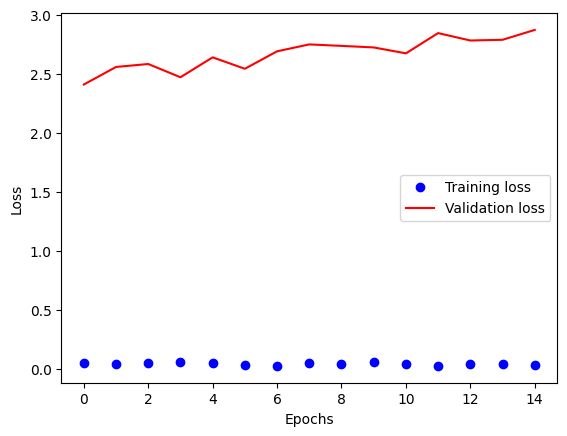

In [35]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline 
#Makes it so plot is only dependent on this block

epochs = range(15)
print(history3.history.keys())
train_acc = history3.history['loss']
valid_acc = history3.history['val_loss']
plt.plot(epochs, train_acc, 'bo', label="Training loss")
plt.plot(epochs, valid_acc, 'r', label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
model3.fit(x_train, y_train_vec, epochs=15, batch_size=128)

Epoch 1/15
391/391 [==============================] - 4s 6ms/step - loss: 1.3820 - accuracy: 0.5061
Epoch 2/15
391/391 [==============================] - 2s 6ms/step - loss: 0.9956 - accuracy: 0.6530
Epoch 3/15
391/391 [==============================] - 3s 7ms/step - loss: 0.8513 - accuracy: 0.7038
Epoch 4/15
391/391 [==============================] - 2s 6ms/step - loss: 0.7410 - accuracy: 0.7414
Epoch 5/15
391/391 [==============================] - 2s 6ms/step - loss: 0.6496 - accuracy: 0.7726
Epoch 6/15
391/391 [==============================] - 2s 6ms/step - loss: 0.5685 - accuracy: 0.8017
Epoch 7/15
391/391 [==============================] - 2s 6ms/step - loss: 0.4869 - accuracy: 0.8290
Epoch 8/15
391/391 [==============================] - 3s 7ms/step - loss: 0.4135 - accuracy: 0.8571
Epoch 9/15
391/391 [==============================] - 2s 6ms/step - loss: 0.3466 - accuracy: 0.8782
Epoch 10/15
391/391 [==============================] - 2s 6ms/step - loss: 0.2835 - accuracy: 0.9021

In [37]:
loss_and_acc3 = model3.evaluate(x_test, y_test_vec)

313/313 [==============================] - 1s 3ms/step - loss: 1.4768 - accuracy: 0.7139


In [43]:
# Idea3: Remove layer
model4 = models.Sequential()
model4.add(layers.BatchNormalization())
model4.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Flatten())
model4.add(layers.Dense(256, activation="relu"))
model4.add(layers.Dense(10, activation="softmax"))

model4.compile(optimizer = 'adam',
              loss='categorical_crossentropy',
              metrics=["accuracy"])

history4 = model4.fit(x_train, y_train_vec, batch_size=128, epochs=15)

Epoch 1/15
391/391 [==============================] - 3s 5ms/step - loss: 1.4232 - accuracy: 0.5005
Epoch 2/15
391/391 [==============================] - 2s 5ms/step - loss: 1.0719 - accuracy: 0.6245
Epoch 3/15
391/391 [==============================] - 2s 6ms/step - loss: 0.9321 - accuracy: 0.6765
Epoch 4/15
391/391 [==============================] - 2s 5ms/step - loss: 0.8283 - accuracy: 0.7124
Epoch 5/15
391/391 [==============================] - 2s 5ms/step - loss: 0.7490 - accuracy: 0.7378
Epoch 6/15
391/391 [==============================] - 2s 5ms/step - loss: 0.6706 - accuracy: 0.7679
Epoch 7/15
391/391 [==============================] - 2s 5ms/step - loss: 0.6115 - accuracy: 0.7872
Epoch 8/15
391/391 [==============================] - 2s 5ms/step - loss: 0.5421 - accuracy: 0.8118
Epoch 9/15
391/391 [==============================] - 3s 6ms/step - loss: 0.4854 - accuracy: 0.8305
Epoch 10/15
391/391 [==============================] - 2s 6ms/step - loss: 0.4251 - accuracy: 0.8511

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


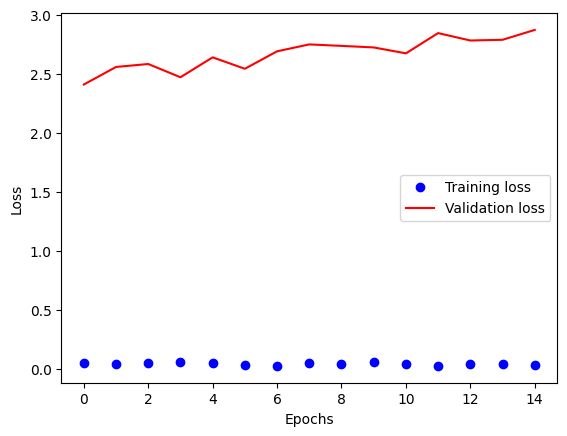

In [42]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline 
#Makes it so plot is only dependent on this block

epochs = range(15)
print(history3.history.keys())
train_acc = history3.history['loss']
valid_acc = history3.history['val_loss']
plt.plot(epochs, train_acc, 'bo', label="Training loss")
plt.plot(epochs, valid_acc, 'r', label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [44]:
model4.evaluate(x_test, y_test_vec)

313/313 [==============================] - 1s 4ms/step - loss: 1.5885 - accuracy: 0.6505


[1.588532567024231, 0.6504999995231628]